# NOAA 自然重建数据的处理

这个笔记本展示如何处理 NOAA 自然重建数据，如何进行贝叶斯组合，如何进行空间代表性分析，并制作论文的第一小节数据插图。

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
import pandas as pd
import numpy as np
import os
from hydra import compose, initialize
from shifting_baseline.utils.log import get_logger, adjust_log_level

with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config.yaml")
os.chdir(cfg.ds.root)

# 在 notebook 中动态调整日志等级
log = get_logger()
adjust_log_level(console_level="INFO", file_level="DEBUG")

In [3]:
# 需要写到论文里的预期结果
expected_results = {
    "n_datasets": None,
    "corr_with_validation": None,
    "n_pass_years": None,
    "sig_sites_percentage": None,
    "sig_sites_ratio": None,
    "n_sites_sig005": None,
    "n_sites_sig01": None,
}

## 筛选与合并数据

### 读取数据

我们一共整理了 13 套在 NOAA 上可以自由下载的[使用树轮重建的古气候数据](https://docs.google.com/spreadsheets/d/1HAICoWO_Uh40iDllIUKE3nYOCVLGNgfWML-6ecTKegU/edit?usp=sharing)。

In [4]:
from shifting_baseline.data import load_nat_data
from shifting_baseline.constants import START

datasets, uncertainties = load_nat_data(
    folder=cfg.ds.noaa,
    includes=cfg.ds.includes,
    start_year=START,
    standardize=True,
)
datasets.tail()

INFO | 从 /Users/songshgeo/Documents/Datasets/东亚古气候重建数据 加载自然数据: li2015b, li2019a, liu2020, shi2017, shi2018, tan2011, xu2023c, yang2016, yang2019d, yi2010, yi2012


Directory /Users/songshgeo/Documents/Datasets/东亚古气候重建数据 checked.
Found 19 files in /Users/songshgeo/Documents/Datasets/东亚古气候重建数据.
Found 9 files matching the pattern.


,yang2019d,yi2010,yang2016,tan2011,xu2023c,liu2020,yi2012,li2015b,li2019a
year,,,,,,,,,
2009,-0.809462,NaN,-0.568723,NaN,-1.466621,-0.314233,NaN,NaN,2.343614
2010,0.515620,NaN,0.307108,NaN,1.170888,-0.302521,NaN,NaN,2.828464
2011,-1.255668,NaN,NaN,NaN,1.248765,-0.760710,NaN,NaN,NaN
2012,NaN,NaN,NaN,NaN,-1.204711,0.169405,NaN,NaN,NaN
2013,NaN,NaN,NaN,NaN,0.140132,0.748762,NaN,NaN,NaN


其中 ，不是所有的数据都会被使用，下面是使用的数据及其时空范围：

In [5]:
import seaborn as sns
from matplotlib import pyplot as plt

# 设置绘图风格
sns.set_theme(style="white")

# 检查数据
for name, ds in datasets.items():
    if name not in cfg.ds.includes:
        print(f"{name} 在使用列表中，但没有读取成功，请检查")
        continue
    index = ds.dropna().index
    print(f"{name} 的时间范围是：{index.min()} - {index.max()}")

# 存储数据集量
expected_results["n_datasets"] = len(datasets.columns)

yang2019d 的时间范围是：1000 - 2011
yi2010 的时间范围是：1600 - 2000
yang2016 的时间范围是：1470 - 2010
tan2011 的时间范围是：1005 - 1975
xu2023c 的时间范围是：1588 - 2013
liu2020 的时间范围是：1493 - 2013
yi2012 的时间范围是：1470 - 2002
li2015b 的时间范围是：1872 - 2003
li2019a 的时间范围是：1000 - 2010


### 合并数据

现在使用贝叶斯组合方法合并数据：

In [6]:
from shifting_baseline.mc import combine_reconstructions

combined, trace = combine_reconstructions(
    datasets,
    uncertainties,
    standardize=True,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_drought, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.


合成的数据进行导出，在其它笔记本中进行进一步分析

In [7]:
# 导出合成数据
combined.to_csv(cfg.ds.out.tree_ring)
uncertainties.to_csv(cfg.ds.out.tree_ring_uncertainty)
combined.head()
print("合成数据导出成功, 路径为:", cfg.ds.out.tree_ring)

,mean,sd,hdi_3%,hdi_97%
year,,,,
1000,-0.156,0.367,-0.874,0.501
1001,-0.059,0.370,-0.738,0.655
1002,0.498,0.446,-0.332,1.329
1003,0.072,0.555,-1.022,1.075
1004,-0.718,0.531,-1.681,0.312


合成数据导出成功, 路径为: /Users/songshgeo/Documents/VSCode/shifting_baseline/data/combined_mean.csv


### 重新加载合成后的数据

INFO | 加载自然数据 [1000-1900]...
INFO | 重新计算自然数据 ...
INFO | 从 /Users/songshgeo/Documents/Datasets/东亚古气候重建数据 加载自然数据: li2015b, li2019a, liu2020, shi2017, shi2018, tan2011, xu2023c, yang2016, yang2019d, yi2010, yi2012


Directory /Users/songshgeo/Documents/Datasets/东亚古气候重建数据 checked.
Found 19 files in /Users/songshgeo/Documents/Datasets/东亚古气候重建数据.
Found 9 files matching the pattern.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_drought, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 20 seconds.


INFO | 加载历史数据 ...
INFO | 处理为对称等级 ...
INFO | 处理为标准化等级 ...
INFO | 通过随机采样处理为标准化等级，生成 100 个样本 ...


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/data.py:218: RuntimeWarning: Mean of empty slice
  np.nanmean(data, axis=0),
/Users/songshgeo/Documents/VSCode/shifting_baseline/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


,name_ch,name_en,region,lon,lat,NAME,省,市,geometry
15,兰州,Lanzhou,华北地区,103.726610,35.181546,临洮县,甘肃省,定西市,POINT (103.72661 35.18155)
16,天水,Tianshui,华北地区,105.600436,34.110788,秦州区,甘肃省,天水市,POINT (105.60044 34.11079)
18,银川,Yinchuan,华北地区,106.135814,37.412291,红寺堡区,宁夏回族自治区,吴忠市,POINT (106.13581 37.41229)
21,榆林,Yulin,华北地区,109.734749,38.066642,横山区,陕西省,榆林市,POINT (109.73475 38.06664)
22,延安,Yan'an,华北地区,109.556290,36.371276,宝塔区,陕西省,延安市,POINT (109.55629 36.37128)


(1000.0, 2000.0)

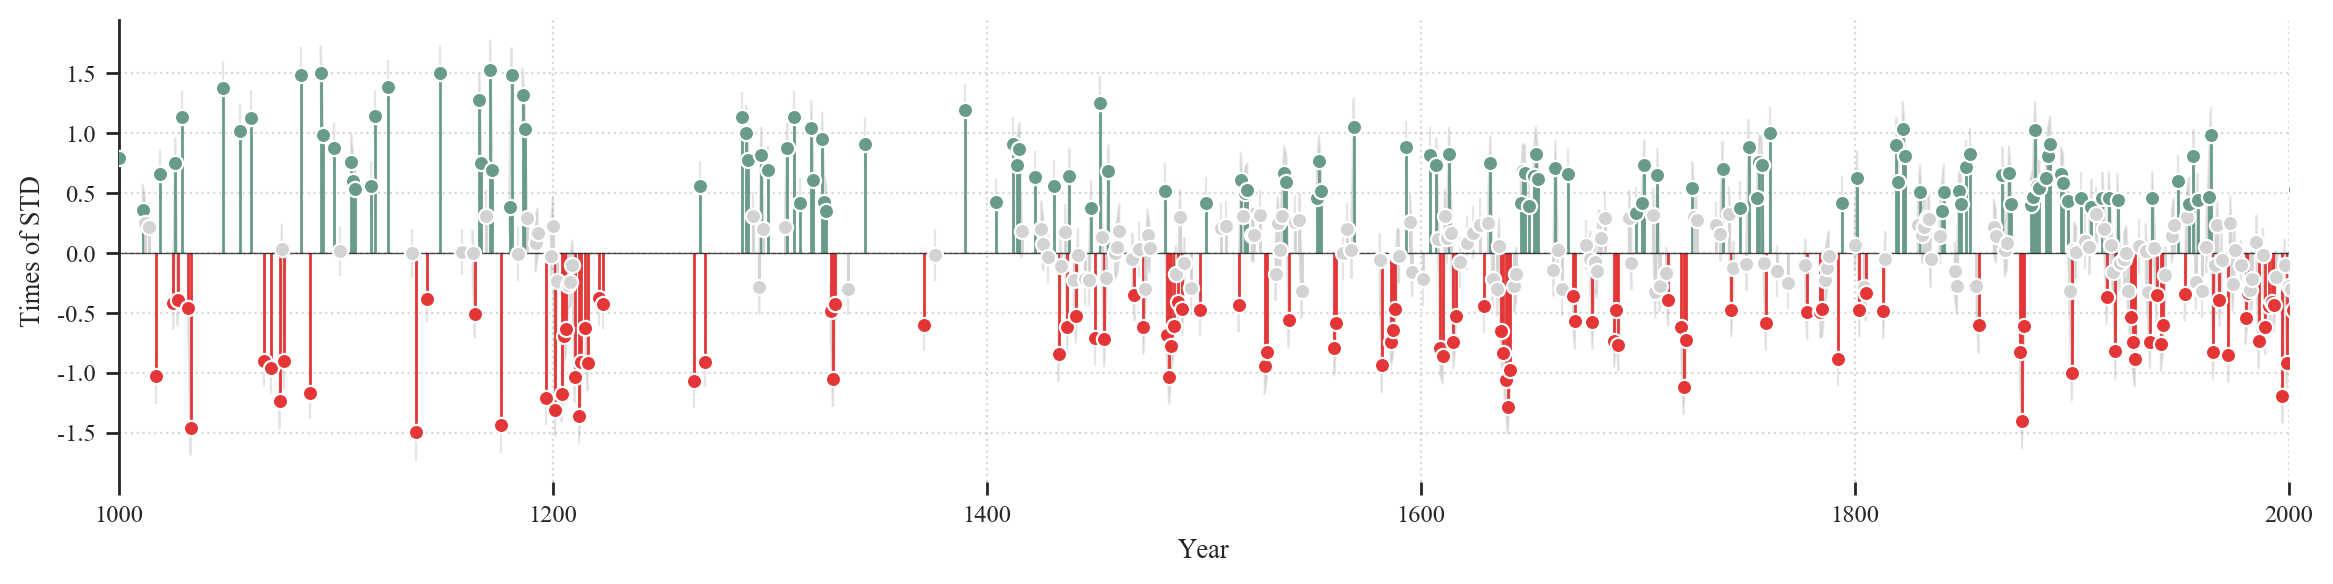

In [8]:
from shifting_baseline.data import HistoricalRecords
from shifting_baseline.utils.plot import plot_std_times
from shifting_baseline.constants import START, FINAL
from shifting_baseline.data import load_data

# 读取合成数据
combined, uncertainties, hist = load_data(cfg)

# 绘制历史数据的时间序列
region_gdf = hist.shp.copy()
region_gdf.head()

pred = hist.aggregate(to_int=False)
std = hist._std.mean(axis=1).ffill()
ax1 = plot_std_times(data=pred)
ax1.fill_between(std.index, pred + std, pred - std, color="gray", alpha=0.2)
ax1.set_xlim(START, FINAL)

## 空间代表性

计算降水量的 z-score, 得到的数据应该包括 1900-2017 年的降水：

[原始数据](https://essd.copernicus.org/articles/11/1931/2019/)来源为 ESSD 的一篇文章，这里只用了夏季（July, August, Sepetember, JAS）三个月的数据，进行聚合之后再升尺度。

注意这里，先计算每个格点 z-score 再平均，和先计算平均降水，再转化成 z-score 效果是不一样的。

我们的先计算了指数，所以再平均的是分数。

In [9]:
from shifting_baseline.data import load_validation_data

# 读取 z-score 数据
validation_data = {}

# 读取每个验证数据，目前有 China, CRU 和 GPCC
for name, validation_ds in cfg.ds.validation.items():
    main_validation_data = name
    # 读取原始数据并重投影
    summer_precip_z, regional_prec_z = load_validation_data(
        data_path=validation_ds.nc,
        resolution=cfg.resolution,
        recalculate_zscore=True,
        nc_save_to=validation_ds.z_nc,
        csv_save_to=validation_ds.csv,
        sel_bound_by=hist,
    )
    validation_data[name] = {
        "z": summer_precip_z,
        "regional": regional_prec_z,
    }

INFO | 从 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/JAS_precip_China_1900-2017.nc 加载验证数据 ...
INFO | 加载原始验证数据（非 z-score） ...
INFO | 加载 China 数据 ...
INFO | 对原始数据计算 z-score ...
INFO | 保存 z-score 验证数据到 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/JAS_z_China_1900-2017.nc ...
INFO | 保存区域降水 z-score 验证数据到 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/JAS_z_China.csv ...
INFO | 从 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/JAS_precip_GPCC_1900-2017.nc 加载验证数据 ...
INFO | 加载原始验证数据（非 z-score） ...
INFO | 加载 GPCC 数据 ...
INFO | 对原始数据计算 z-score ...
INFO | 保存 z-score 验证数据到 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/JAS_z_GPCC_1900-2017.nc ...
INFO | 保存区域降水 z-score 验证数据到 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/JAS_z_GPCC.csv ...
INFO | 从 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/JAS_precip_CRU_1900-2017.nc 加载验证数据 ...
INFO | 加载原始验证数据（非 z-score） ...
INFO | 加载 CRU 数据 ...
INFO | 对原始数据计算 z-score ...
INFO | 保存 z-sc

In [10]:
from shifting_baseline.data import load_validation_data

# 读取 z-score 数据
validation_data = {}

# 读取每个验证数据，目前有 China, CRU 和 GPCC
for name, validation_ds in cfg.ds.validation.items():
    main_validation_data = name
    # 读取原始数据并重投影
    summer_precip_z, regional_prec_z = load_validation_data(
        data_path=validation_ds.z_nc,
        resolution=cfg.resolution,
        csv_save_to=validation_ds.csv,
        nc_save_to=validation_ds.z_nc,
        crs="EPSG:4326",
    )
    validation_data[name] = {
        "z": summer_precip_z,
        "regional": regional_prec_z,
    }

INFO | 从 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/JAS_z_China_1900-2017.nc 加载验证数据 ...
INFO | 从文件加载处理后的 z-score 验证数据 ...
INFO | 从 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/JAS_z_China.csv 加载区域降水 z-score 验证数据 ...
INFO | 从 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/JAS_z_GPCC_1900-2017.nc 加载验证数据 ...
INFO | 从文件加载处理后的 z-score 验证数据 ...
INFO | 从 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/JAS_z_GPCC.csv 加载区域降水 z-score 验证数据 ...
INFO | 从 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/JAS_z_CRU_1900-2017.nc 加载验证数据 ...
INFO | 从文件加载处理后的 z-score 验证数据 ...
INFO | 从 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/JAS_z_CRU.csv 加载区域降水 z-score 验证数据 ...


首先计算看看每个数据的空间代表性。

/var/folders/s9/w7bh_d6x1h915wcvpbp117tm0000gn/T/ipykernel_24070/333971423.py:71: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="upper left")


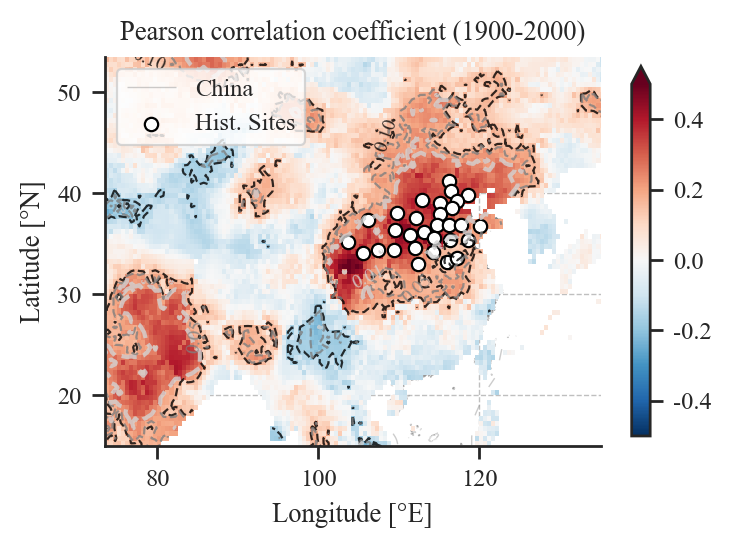

In [11]:
import geopandas as gpd
from matplotkit import with_axes
from shifting_baseline.constants import END
from shifting_baseline.utils.calc import calc_corr
from shifting_baseline.utils.plot import plot_corr_map
import xarray as xr


def set_to_bounds(
    outline,
    min_x: float = None,
    max_x: float = None,
    min_y: float = None,
    max_y: float = None,
):
    xmin = outline.bounds.minx.min()
    xmax = outline.bounds.maxx.max()
    ymin = outline.bounds.miny.min()
    ymax = outline.bounds.maxy.max()
    if min_x is not None:
        xmin = min_x
    if max_x is not None:
        xmax = max_x
    if min_y is not None:
        ymin = min_y
    if max_y is not None:
        ymax = max_y
    return (xmin, xmax), (ymin, ymax)


def calc_spatial_corr(series, validation_z, crs: str = "EPSG:4326"):
    """
    计算空间相关性
    """
    common_years = np.intersect1d(series.year.values, validation_z.year.values)

    corr = xr.apply_ufunc(
        calc_corr,
        validation_z.sel(year=common_years),
        series.sel(year=common_years),
        input_core_dims=[["year"], ["year"]],
        output_core_dims=[[], [], []],
        vectorize=True,
        output_dtypes=[float, float, int],
    )
    return corr


@with_axes(figsize=(4, 3))
def plot_spatial_corr(corr, crs: str = "EPSG:4326", ax=None):
    """
    绘制空间相关性
    """
    china_outline = gpd.read_file(cfg.ds.base_maps.china).to_crs(crs)
    xlim, ylim = set_to_bounds(china_outline, min_y=15)
    ax = plot_corr_map(
        corr[0],
        corr[1],
        threshold=0.1,
        mask=False,
        crs=crs,
        base_maps=cfg.ds.base_maps,
        ax=ax,
    )
    region_gdf.plot(ax=ax, color="white", edgecolor="black", label="Hist. Sites")
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_title(f"Pearson correlation coefficient ({END}-{FINAL})")
    ax.set_xlabel("Longitude [°E]")
    ax.set_ylabel("Latitude [°N]")
    ax.legend(loc="upper left")
    return ax


series = combined["mean"].to_xarray()
ax1 = plot_spatial_corr(calc_spatial_corr(series, summer_precip_z))
plt.show();

使用三种校验数据进行空间相关性作图

/var/folders/s9/w7bh_d6x1h915wcvpbp117tm0000gn/T/ipykernel_24070/333971423.py:71: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="upper left")
/var/folders/s9/w7bh_d6x1h915wcvpbp117tm0000gn/T/ipykernel_24070/333971423.py:71: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="upper left")
/var/folders/s9/w7bh_d6x1h915wcvpbp117tm0000gn/T/ipykernel_24070/333971423.py:71: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="upper left")


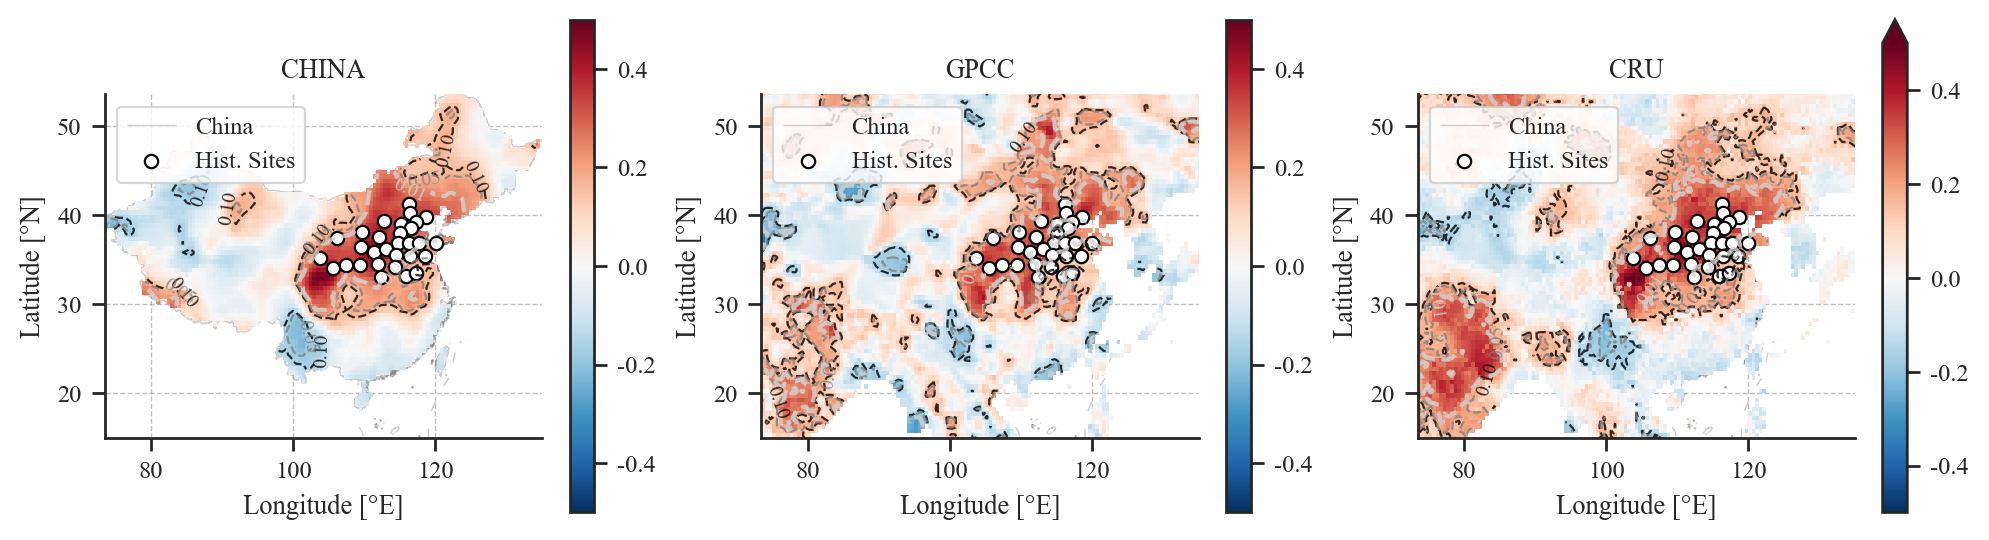

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i, (name, ds) in enumerate(validation_data.items()):
    ax1 = axs[i]
    nc = ds["z"]
    csv = ds["regional"]
    ax1 = plot_spatial_corr(calc_spatial_corr(series, nc), ax=ax1)
    ax1.set_title(name.upper())
plt.show();

再计算一下时间上有没有时滞

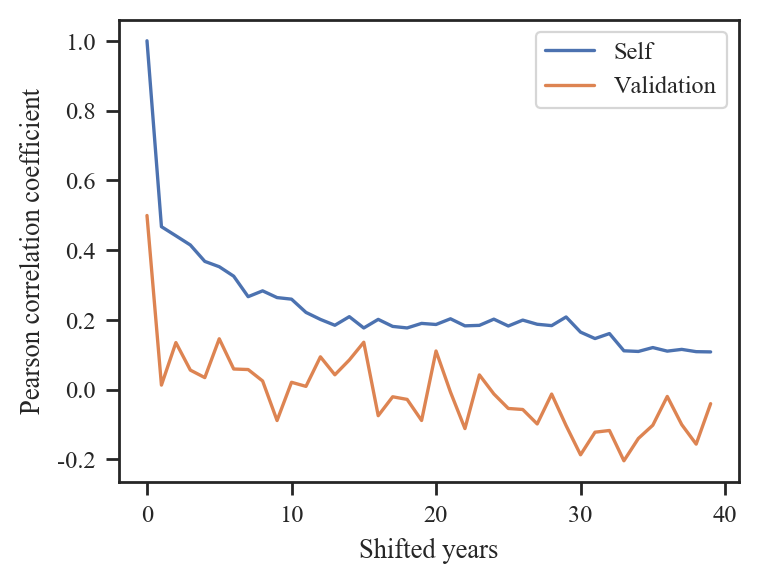

In [13]:
shifts = np.arange(0, 40)
corrs_with_self = []
corrs_with_validation = []
for shift in shifts:
    shifted = combined["mean"].shift(shift)
    corrs_with_self.append(combined["mean"].corr(shifted))
    corrs_with_validation.append(regional_prec_z.corr(shifted))

plt.figure(figsize=(4, 3))
plt.xlabel("Shifted years")
plt.ylabel("Pearson correlation coefficient")
plt.plot(shifts, corrs_with_self, label="Self")
plt.plot(shifts, corrs_with_validation, label="Validation")
plt.legend()
plt.show();

## 分布测定

最佳分布：Student-t（t）表现最佳：

- 最低sumsquare_error（1.003480），表明直方图拟合最好。
- 较低的AIC（495.670695）和BIC（507.652580），优于lognorm和gamma。
- 最低ks_statistic（0.040494）和最高ks_pvalue（0.5134515），CDF拟合极佳。

次佳分布：lognorm：
- sumsquare_error（1.010543）、AIC（500.570491）、BIC（512.552375）略逊于t。
- ks_statistic（0.040599）和ks_pvalue（0.5101007）与t接近，拟合良好。

In [14]:
from shifting_baseline.data import check_distribution
from matplotlib import pyplot as plt


summary = check_distribution(combined["mean"], only_best=False)

summary
log.info(f"可以看出，对树轮数据的最佳分布拟合是：{summary.index[0]}")

2025-09-28 15:54:51.391 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=10.061054)
2025-09-28 15:54:51.405 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=2.026909)
2025-09-28 15:54:51.412 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distribution with error=0.807445)
2025-09-28 15:54:51.425 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=0.755059)
2025-09-28 15:54:51.442 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted lognorm distribution with error=0.742691)
2025-09-28 15:54:51.446 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted exponpow distribution with error=0.957899)
2025-09-28 15:54:51.473 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=6.00872)
2025-09-28 15:54:51.487 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted 

INFO | 最佳分布: sumsquare_error      0.737482
aic                355.676411
bic                365.519727
kl_div                    inf
ks_statistic         0.020725
ks_pvalue            0.768249
Name: norm, dtype: float64


2025-09-28 15:54:51.610 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted t distribution with error=0.737483)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,0.737482,355.676411,365.519727,inf,0.020725,0.768249
t,0.737483,357.676535,372.441510,inf,0.020726,0.768222
lognorm,0.742691,358.081768,372.846743,inf,0.021967,0.703492
gamma,0.755059,358.058732,372.823707,inf,0.024405,0.573161
chi2,0.807445,357.297021,372.061996,inf,0.033410,0.203120


INFO | 可以看出，对树轮数据的最佳分布拟合是：norm


合并后的数据符合正态分布

### 历史站点分布在哪里

把每个历史材料站点所在位置的【树轮 v.s. 校验】数据相关性进行记录。

In [15]:
def calc_sites_corr(corr, region_gdf, name: str = "") -> pd.DataFrame:
    """
    计算历史站点相关性
    """
    log.info(f"计算 {name} 数据与历史站点相关性")
    rs, ps = [], []
    for lon, lat in zip(region_gdf.lon, region_gdf.lat):
        r = corr[0].sel(x=lon, y=lat, method="nearest").item()
        p = corr[1].sel(x=lon, y=lat, method="nearest").item()
        rs.append(r)
        ps.append(p)

    results = pd.DataFrame()
    results["name_en"] = region_gdf["name_en"]
    col_name = f"{name}_r" if name else "r"
    results[col_name] = rs
    col_name = f"{name}_p" if name else "p"
    results[col_name] = ps
    # 计算显著性水平
    mask = results[col_name] < 0.1
    mask2 = results[col_name] < 0.05
    n_sig = mask.sum()
    n_sig2 = mask2.sum()
    log.info(f"一共有 {len(results)} 个站点，其中：")
    log.info(f"有 {n_sig} 个站点通过了 0.1 显著性水平检验 ({n_sig/len(results):.2%})")
    log.info(f"有 {n_sig2} 个站点通过了 0.05 显著性水平检验 ({n_sig2/len(results):.2%})")
    return results


sites_corr = pd.DataFrame()
sites_corr["name_en"] = region_gdf["name_en"]
for name, ds in validation_data.items():
    corr = calc_spatial_corr(series, ds["z"])
    hist_sites_corr = calc_sites_corr(corr, region_gdf, name)
    sites_corr = pd.merge(sites_corr, hist_sites_corr, on=["name_en"])

sites_corr.head()

INFO | 计算 china 数据与历史站点相关性
INFO | 一共有 30 个站点，其中：
INFO | 有 29 个站点通过了 0.1 显著性水平检验 (96.67%)
INFO | 有 28 个站点通过了 0.05 显著性水平检验 (93.33%)
INFO | 计算 gpcc 数据与历史站点相关性
INFO | 一共有 30 个站点，其中：
INFO | 有 28 个站点通过了 0.1 显著性水平检验 (93.33%)
INFO | 有 26 个站点通过了 0.05 显著性水平检验 (86.67%)
INFO | 计算 cru 数据与历史站点相关性
INFO | 一共有 30 个站点，其中：
INFO | 有 27 个站点通过了 0.1 显著性水平检验 (90.00%)
INFO | 有 26 个站点通过了 0.05 显著性水平检验 (86.67%)


,name_en,china_r,china_p,gpcc_r,gpcc_p,cru_r,cru_p
0,Lanzhou,0.314234,0.000700,0.275194,0.002066,0.278341,0.002835
1,Tianshui,0.379272,0.000034,0.320591,0.000300,0.386632,0.000023
2,Yinchuan,0.260608,0.005306,0.291004,0.001093,0.316517,0.000637
3,Yulin,0.341391,0.000215,0.168317,0.062749,0.276402,0.003042
4,Yan'an,0.400846,0.000011,0.275226,0.002063,0.438720,0.000001


## 对比自然数据与校验数据

这里我们将展示自然数据的：

- 年值
- 30 年低通滤波
- 上下 1 倍 RMSE 的范围


INFO | china 数据相关性为 0.5352679932908917
INFO | gpcc 数据相关性为 0.546988317775901
INFO | 最佳相关性为 0.55，来自 gpcc 数据


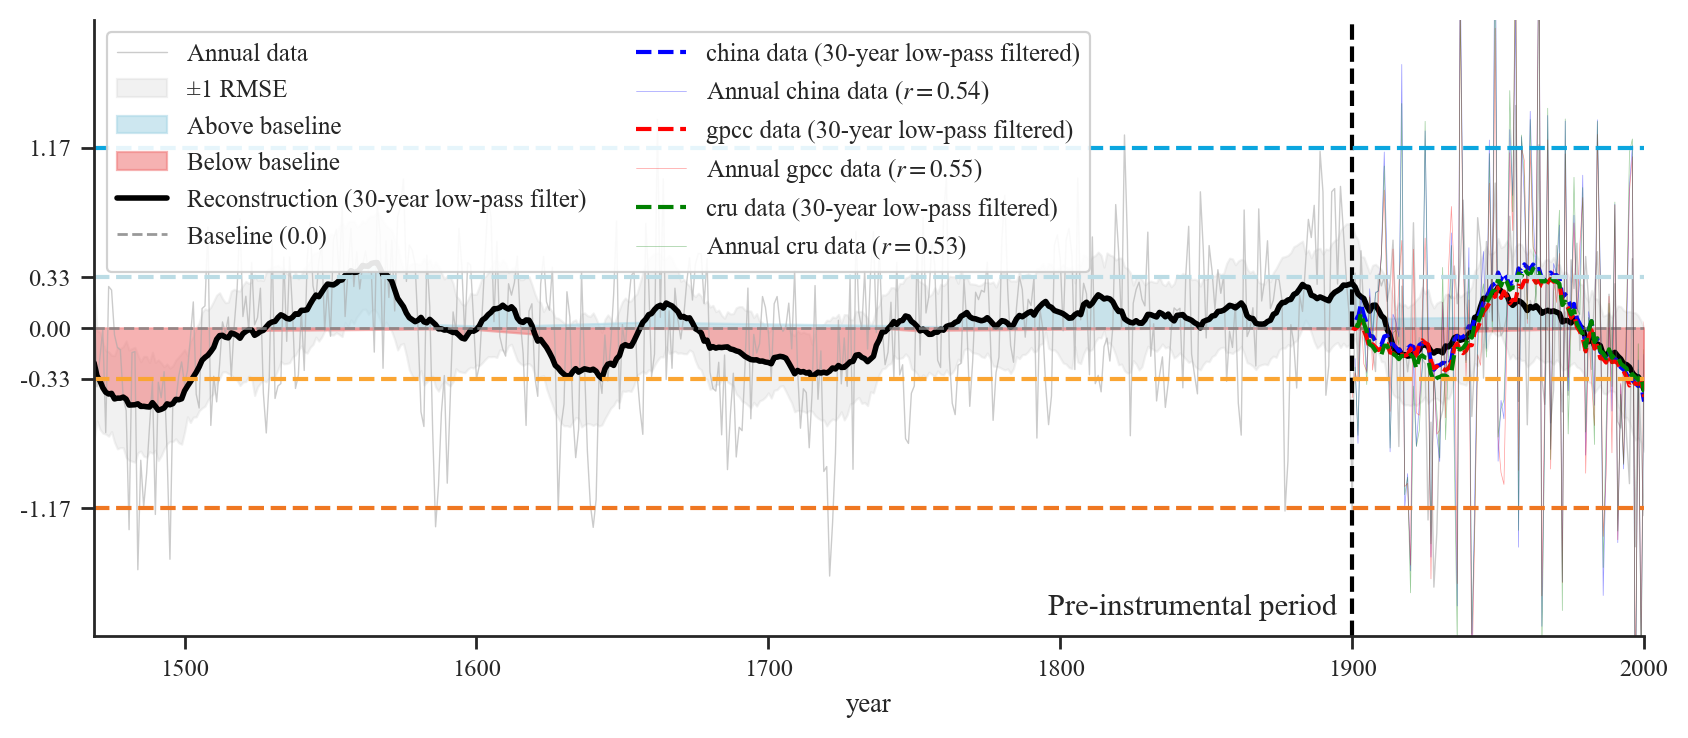

In [16]:
from shifting_baseline.utils.plot import plot_time_series_with_lowpass
from shifting_baseline.utils.calc import low_pass_filter
from shifting_baseline.constants import (
    STAGE1,
    END,
    FINAL,
    THRESHOLDS,
    COLORS,
    STD_THRESHOLDS,
)

tree_ring_z = combined["mean"].loc[STAGE1:FINAL]
tree_ring_std = combined["sd"].loc[STAGE1:FINAL]
# 低通滤波
low_pass_cfg = cfg.get("low_pass", {})
mean_pass = low_pass_filter(tree_ring_z, **low_pass_cfg)
validation_corr = regional_prec_z.corr(tree_ring_z.loc[END:FINAL])

# 绘制时间序列
ax1 = plot_time_series_with_lowpass(
    data=tree_ring_z,
    filtered_data=mean_pass,
    baseline=0,
    rmse_data=tree_ring_std,
)

colors = ["blue", "red", "green"]
best_val_data = None
best_corr = 0
for i, name in enumerate(validation_data.keys()):
    val_data = validation_data[name]["regional"].loc[END:FINAL]
    color = colors[i]
    corr = val_data.corr(tree_ring_z.loc[END:FINAL])
    low_pass_filter(val_data, **low_pass_cfg).plot(
        ax=ax1,
        color=color,
        lw=1.5,
        ls="--",
        label=f"{name} data (30-year low-pass filtered)",
    )
    val_data.plot(
        ax=ax1,
        color=color,
        lw=0.25,
        alpha=0.4,
        label=f"Annual {name} data ($r={corr:.2f}$)",
    )
    if corr > best_corr:
        log.info("%s 数据相关性为 %s", name, corr)
        best_corr = corr
        best_val_data = name

log.info(f"最佳相关性为 {best_corr:.2f}，来自 {best_val_data} 数据")
ax1.axvline(END, color="black", lw=1.5, ls="--")
ax1.text(END - 5, -1.9, "Pre-instrumental period", ha="right", va="bottom", fontsize=11)

for th, color in zip(THRESHOLDS, COLORS):
    ax1.axhline(th, color=color, lw=1.5, ls="--")
# 设置图例
ax1.legend(loc="upper left", fontsize=9, framealpha=0.9, ncol=2)
ax1.set_xlim(STAGE1, FINAL)
ax1.set_yticks(STD_THRESHOLDS)
ax1.set_ylim(-2, 2)
ax1.set_title("")

plt.show();

绘制合并后的数据可以看出，在第一个阶段波动更明显；1700 之后的波动没有那么明显。

## 对比历史数据与树轮数据

INFO | 共同索引长度: 432
INFO | t 检验: 0.003960862380600078


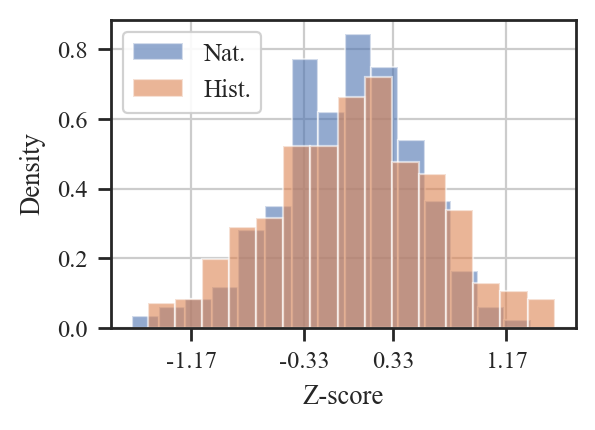

In [17]:
from scipy.stats import ttest_rel

fig, ax1 = plt.subplots(figsize=(3, 2))
tree_ring_subset = tree_ring_z.loc[STAGE1:END]
tree_ring_subset.hist(density=True, alpha=0.6, bins=15, ax=ax1, label="Nat.")

# 历史数据
agg_hist = hist.aggregate(cfg.agg_method, to_int=False)
agg_hist.hist(density=True, alpha=0.6, bins=15, ax=ax1, label="Hist.")

# 确保两个序列有相同的时间范围
common_index = tree_ring_subset.index.intersection(agg_hist.index)
log.info("共同索引长度: %s", len(common_index))

if len(common_index) == 0:
    raise ValueError("没有共同索引，无法进行 t 检验")

# 使用共同索引进行 t 检验
tree_ring_aligned = tree_ring_subset.loc[common_index]
agg_hist_aligned = agg_hist.loc[common_index]

# 检查是否有缺失值
log.debug("tree_ring_aligned 缺失值数量: %s", tree_ring_aligned.isna().sum())
log.debug("agg_hist_aligned 缺失值数量: %s", agg_hist_aligned.isna().sum())

# 移除缺失值
valid_mask = ~(tree_ring_aligned.isna() | agg_hist_aligned.isna())
tree_ring_clean = tree_ring_aligned[valid_mask]
agg_hist_clean = agg_hist_aligned[valid_mask]

log.debug("清理后 tree_ring 形状: %s", tree_ring_clean.shape)
log.debug("清理后 agg_hist 形状: %s", agg_hist_clean.shape)

if len(tree_ring_clean) == 0:
    raise ValueError("没有有效数据，无法进行 t 检验")

ttest = ttest_rel(tree_ring_clean, agg_hist_clean)
log.info("t 检验: %s", ttest.pvalue)

ax1.legend(loc="upper left", fontsize=9, framealpha=0.9, ncol=1)
ax1.set_xticks(THRESHOLDS)
ax1.set_xlabel("Z-score")
ax1.set_ylabel("Density")
ax1.set_title("")
plt.show();

In [18]:
summary = check_distribution(agg_hist, only_best=False)
summary

log.info(f"可以看出，对树轮数据的最佳分布拟合是：{summary.index[0]}")

2025-09-28 15:55:07.185 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted expon distribution with error=11.237636)
2025-09-28 15:55:07.194 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted chi2 distribution with error=20.975533)
2025-09-28 15:55:07.202 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted norm distribution with error=2.623986)
2025-09-28 15:55:07.203 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted powerlaw distribution with error=6.587533)
2025-09-28 15:55:07.204 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted rayleigh distribution with error=4.089736)
2025-09-28 15:55:07.205 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted uniform distribution with error=6.873181)
2025-09-28 15:55:07.206 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted gamma distribution with error=2.637715)
2025-09-28 15:55:07.216 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted 

INFO | 最佳分布: sumsquare_error      2.623986
aic                296.172195
bic                304.281074
kl_div                    inf
ks_statistic         0.020047
ks_pvalue            0.994272
Name: norm, dtype: float64


2025-09-28 15:55:07.929 | INFO     | fitter.fitter:_fit_single_distribution:333 - Fitted cauchy distribution with error=3.712039)


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,2.623986,296.172195,304.281074,inf,0.020047,0.994272
t,2.623986,298.172288,310.335606,inf,0.020047,0.994272
lognorm,2.630204,298.069447,310.232765,inf,0.022028,0.983087
gamma,2.637715,298.098944,310.262262,inf,0.023778,0.964871
exponpow,2.754359,283.411997,295.575315,inf,0.035584,0.640046


INFO | 可以看出，对树轮数据的最佳分布拟合是：norm


## 最终作图

图 1 我希望包括以下内容：

- 证明对数论数据的拟合效果不错
- 证明历史数据和数论数据都能在基本的旱涝历史上达到一致
- 证明空间上有代表性
- 证明历史判断比树轮的判断更极端

WARNING | 使用指定的校验数据: china


INFO | 处理为对称等级 ...
INFO | 处理为标准化等级 ...
INFO | 通过随机采样处理为标准化等级，生成 100 个样本 ...


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/data.py:218: RuntimeWarning: Mean of empty slice
  np.nanmean(data, axis=0),
/Users/songshgeo/Documents/VSCode/shifting_baseline/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/s9/w7bh_d6x1h915wcvpbp117tm0000gn/T/ipykernel_24070/333971423.py:71: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc="upper left")
/var/folders/s9/w7bh_d6x1h915wcvpbp117tm0000gn/T/ipykernel_24070/2295467866.py:109: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax3.legend(loc="upper left", fontsize=9, fram

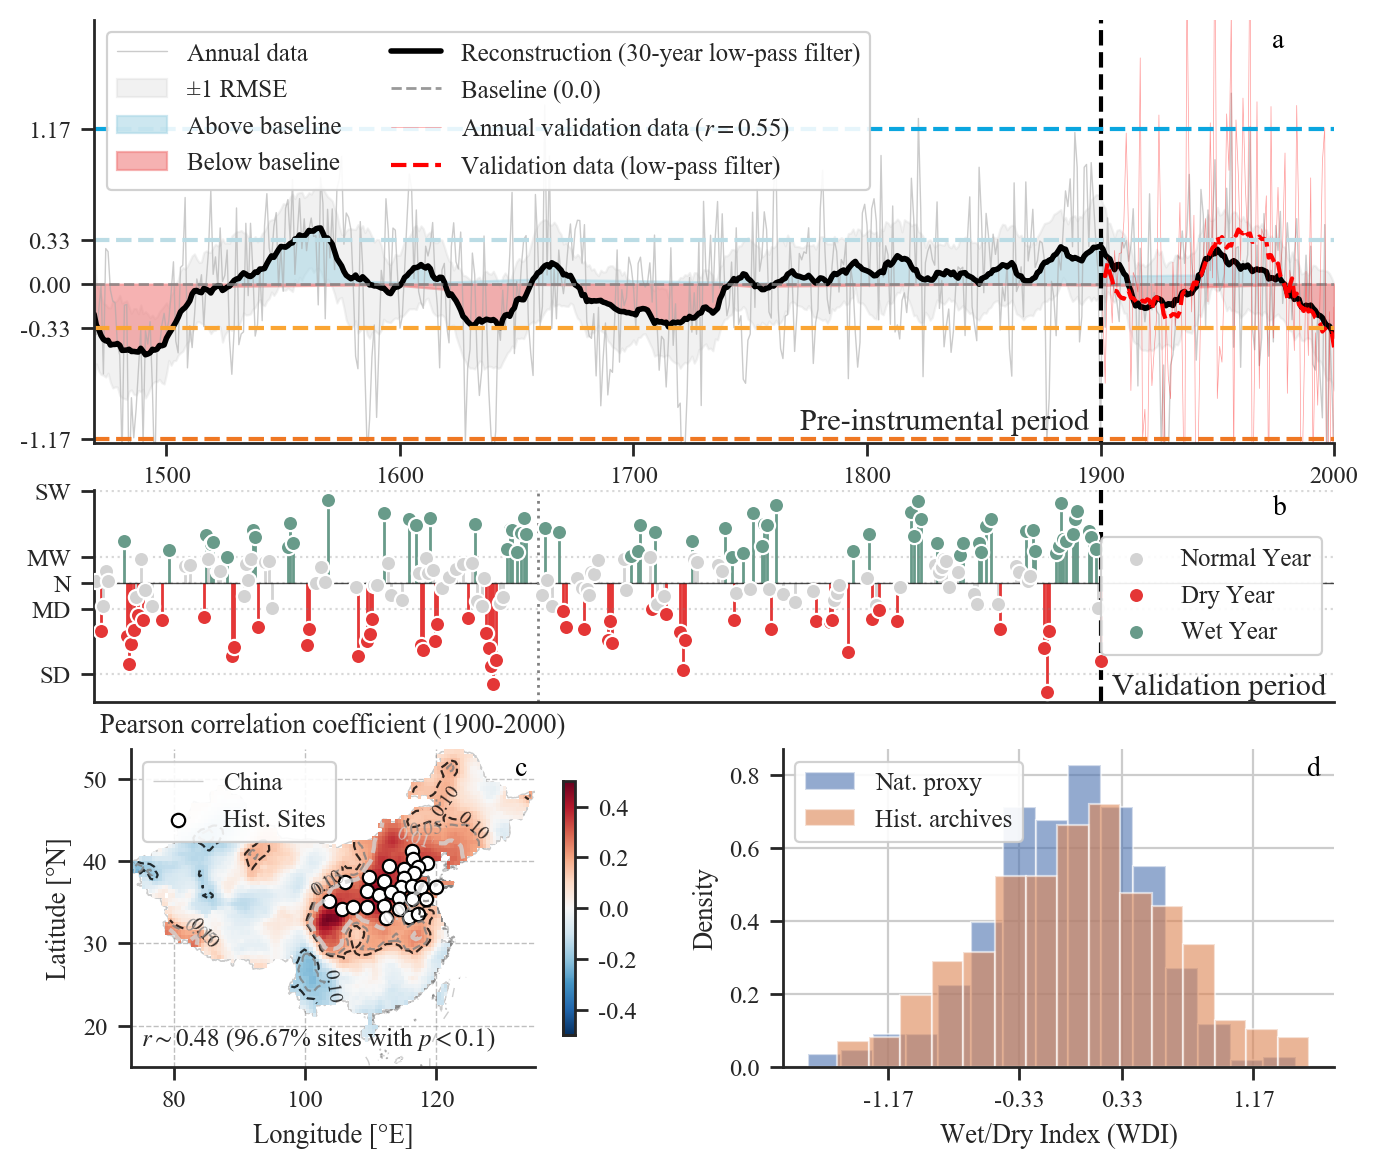

In [19]:
from shifting_baseline.utils.plot import plot_std_times
from shifting_baseline.constants import TICK_LABELS, STAGE2


using_val_data = cfg.get("using_val_data", None)
if using_val_data:
    log.warning("使用指定的校验数据: %s", using_val_data)
    best_val_data = using_val_data
else:
    log.info("当前没有指定校验数据，使用自动检测的最佳数据 %s", best_val_data)

fig = plt.figure(figsize=(8, 6.8), constrained_layout=False)
gs = fig.add_gridspec(
    3,
    2,
    hspace=0.15,
    wspace=0.25,
    width_ratios=[1, 1],
    height_ratios=[2, 1, 1.5],
)

# ================================================
# 自然数据
ax1 = fig.add_subplot(gs[0, :])
best_val_series = validation_data[best_val_data]["regional"].loc[END:FINAL]
best_val_map = validation_data[best_val_data]["z"]
best_sites_corr = sites_corr[f"{best_val_data}_r"].max()
num_sig_sites = sites_corr[f"{best_val_data}_p"] < 0.1

# 绘制时间序列
ax1 = plot_time_series_with_lowpass(
    data=tree_ring_z,
    filtered_data=mean_pass,
    baseline=0,
    rmse_data=tree_ring_std,
    ax=ax1,
)

best_val_series.plot(
    ax=ax1,
    color="red",
    lw=0.25,
    alpha=0.4,
    label=f"Annual validation data ($r={best_corr:.2f}$)",
)
low_pass_filter(best_val_series, **low_pass_cfg).plot(
    ax=ax1,
    color="red",
    lw=1.5,
    ls="--",
    label="Validation data (low-pass filter)",
)
ax1.axvline(END, color="black", lw=1.5, ls="--")
ax1.text(
    END - 5, -1.15, "Pre-instrumental period", ha="right", va="bottom", fontsize=11
)

for th, color in zip(THRESHOLDS, COLORS):
    ax1.axhline(th, color=color, lw=1.5, ls="--")
# 设置图例
ax1.legend(loc="upper left", fontsize=9, framealpha=0.9, ncol=2)
ax1.set_xlim(STAGE1, FINAL)
ax1.set_yticks(STD_THRESHOLDS)
ax1.set_ylim(-1.2, 2)
ax1.set_title("")

# ================================================
# 历史数据
# 绘制历史数据，看看哪些年份有记录
ax2 = fig.add_subplot(gs[1, :])

history = HistoricalRecords(
    shp_path=cfg.ds.atlas.shp,
    data_path=cfg.ds.atlas.file,
    symmetrical_level=True,
    to_std=cfg.to_std,
)

data = history.aggregate(to_int=False).loc[STAGE1:END]
# low_pass_filter(data=data).fillna(0).plot(
#     ax=ax2, color="black", lw=1.5, label="Filtered"
# )
ax2 = plot_std_times(data, ax=ax2, zorder=-1)
ax2.set_yticks(STD_THRESHOLDS)
ax2.set_xlim(STAGE1, FINAL)
ax2.set_yticklabels(TICK_LABELS)
ax2.axvline(END, color="black", lw=1.5, ls="--")
ax2.axvline(STAGE2, color="gray", lw=1, ls=":")
ax2.set_ylabel("")
ax2.legend(loc="center right", fontsize=9, framealpha=0.9, ncol=1)
ax2.text(END + 5, -1.5, "Validation period", ha="left", va="bottom", fontsize=11)

# ================================================
# 空间分布
ax3 = fig.add_subplot(gs[2, 0])
ax3 = plot_spatial_corr(
    calc_spatial_corr(combined["mean"].to_xarray(), best_val_map), ax=ax3
)
ax3.set_xlabel("Longitude [°E]")
ax3.set_ylabel("Latitude [°N]")
ax3.text(
    75,
    20,
    f"$r\sim{best_sites_corr:.2f}$ ({num_sig_sites.sum()/len(sites_corr):.2%} sites with $p<0.1$)",
    ha="left",
    va="top",
    fontsize=9,
)
ax3.legend(loc="upper left", fontsize=9, framealpha=0.9, ncol=1)

## ================================================
BINS = 15
ax4 = fig.add_subplot(gs[2, 1])
tree_ring_z.hist(density=True, alpha=0.6, bins=BINS, ax=ax4, label="Nat. proxy")
agg_hist.hist(density=True, alpha=0.6, bins=BINS, ax=ax4, label="Hist. archives")
ax4.set_ylabel("Density")
ax4.set_xlabel("Wet/Dry Index (WDI)")
ax4.set_xticks(THRESHOLDS)
ax4.legend(loc="upper left", fontsize=9, framealpha=0.9, ncol=1)

# ================================================
# 设置整体作图的样式
for ax in fig.axes:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
ax2.get_xaxis().set_visible(False)

# 子图添加标签（a, b, c, d）
for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    ax.text(
        0.95,
        0.98,
        f"{chr(97 + i)}",
        weight="bold",
        ha="left",
        va="top",
        fontsize=10,
        transform=ax.transAxes,
        color="black",
    )
plt.show();

### 测试每个数据被删除一遍

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_drought, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.


INFO | 保存删除 yang2019d 后的数据到 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/mac/yang2019d_del.csv。
INFO | 处理为对称等级 ...
INFO | 处理为标准化等级 ...
INFO | 通过随机采样处理为标准化等级，生成 100 个样本 ...
INFO | 开始计算历史数据和重建数据的相关性
INFO | cfg.agg_method=mean; cfg.to_int=True.
INFO | 开始计算相关性 kendall，时间切片: slice(1469, 1900, None)
INFO | 基准相关系数: 0.51309


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/data.py:218: RuntimeWarning: Mean of empty slice
  np.nanmean(data, axis=0),
/Users/songshgeo/Documents/VSCode/shifting_baseline/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


INFO | 最大相关性系数: 0.54647，改进百分比: 6.51%
INFO | 最大相关性系数年份: 16.0


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/compare.py:225: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  log.info("最大相关性系数年份: %s", float(filtered_df.idxmax().max()))


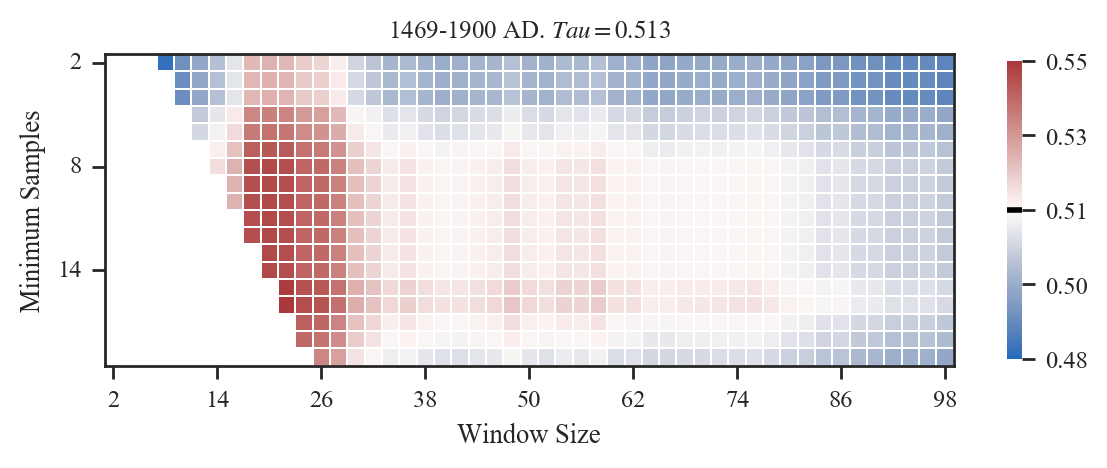

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_drought, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 19 seconds.


INFO | 保存删除 yi2010 后的数据到 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/mac/yi2010_del.csv。
INFO | 处理为对称等级 ...
INFO | 处理为标准化等级 ...
INFO | 通过随机采样处理为标准化等级，生成 100 个样本 ...
INFO | 开始计算历史数据和重建数据的相关性
INFO | cfg.agg_method=mean; cfg.to_int=True.
INFO | 开始计算相关性 kendall，时间切片: slice(1469, 1900, None)
INFO | 基准相关系数: 0.43073


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/data.py:218: RuntimeWarning: Mean of empty slice
  np.nanmean(data, axis=0),
/Users/songshgeo/Documents/VSCode/shifting_baseline/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


INFO | 最大相关性系数: 0.46921，改进百分比: 8.93%
INFO | 最大相关性系数年份: 16.0


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/compare.py:225: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  log.info("最大相关性系数年份: %s", float(filtered_df.idxmax().max()))


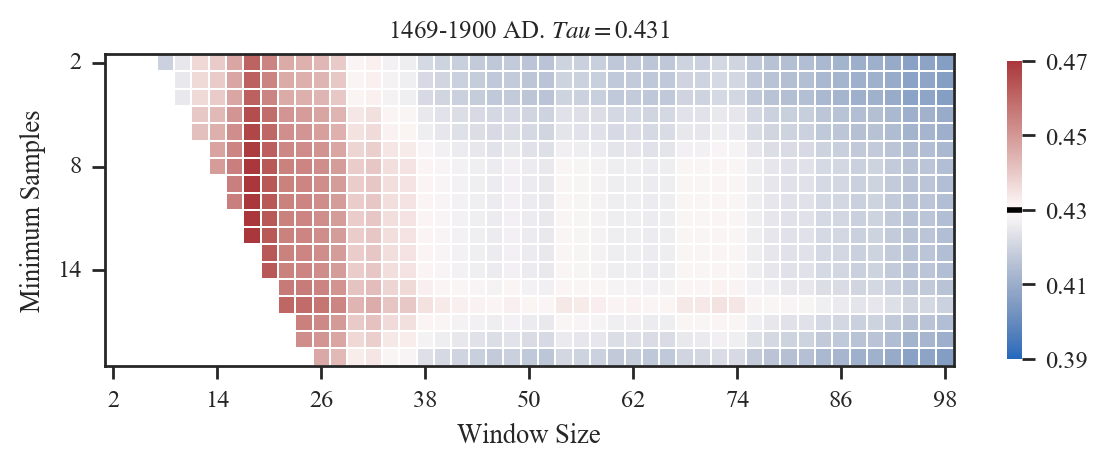

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_drought, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.


INFO | 保存删除 yang2016 后的数据到 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/mac/yang2016_del.csv。
INFO | 处理为对称等级 ...
INFO | 处理为标准化等级 ...
INFO | 通过随机采样处理为标准化等级，生成 100 个样本 ...
INFO | 开始计算历史数据和重建数据的相关性
INFO | cfg.agg_method=mean; cfg.to_int=True.
INFO | 开始计算相关性 kendall，时间切片: slice(1469, 1900, None)
INFO | 基准相关系数: 0.42539


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/data.py:218: RuntimeWarning: Mean of empty slice
  np.nanmean(data, axis=0),
/Users/songshgeo/Documents/VSCode/shifting_baseline/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


INFO | 最大相关性系数: 0.44110，改进百分比: 3.69%
INFO | 最大相关性系数年份: 16.0


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/compare.py:225: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  log.info("最大相关性系数年份: %s", float(filtered_df.idxmax().max()))


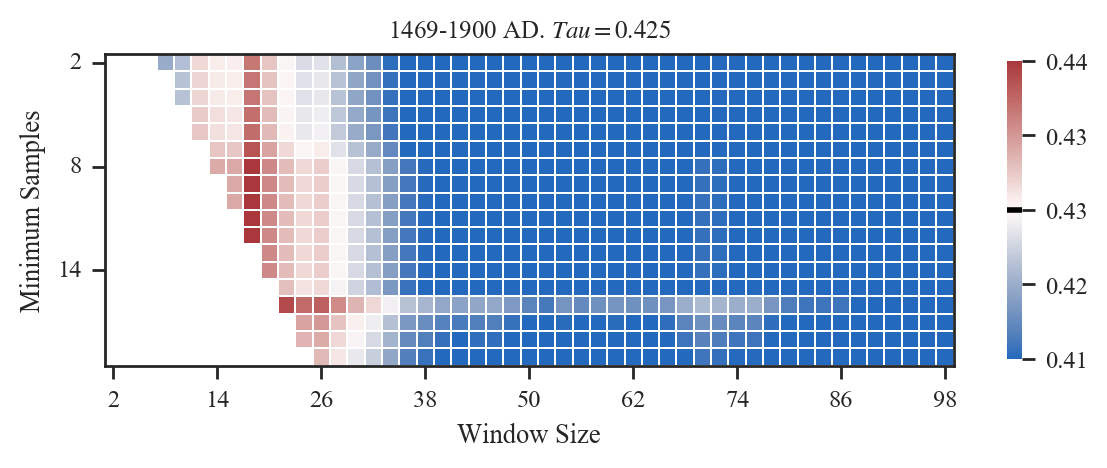

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_drought, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.


INFO | 保存删除 tan2011 后的数据到 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/mac/tan2011_del.csv。
INFO | 处理为对称等级 ...
INFO | 处理为标准化等级 ...
INFO | 通过随机采样处理为标准化等级，生成 100 个样本 ...
INFO | 开始计算历史数据和重建数据的相关性
INFO | cfg.agg_method=mean; cfg.to_int=True.
INFO | 开始计算相关性 kendall，时间切片: slice(1469, 1900, None)
INFO | 基准相关系数: 0.46383


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/data.py:218: RuntimeWarning: Mean of empty slice
  np.nanmean(data, axis=0),
/Users/songshgeo/Documents/VSCode/shifting_baseline/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


INFO | 最大相关性系数: 0.49600，改进百分比: 6.93%
INFO | 最大相关性系数年份: 16.0


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/compare.py:225: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  log.info("最大相关性系数年份: %s", float(filtered_df.idxmax().max()))


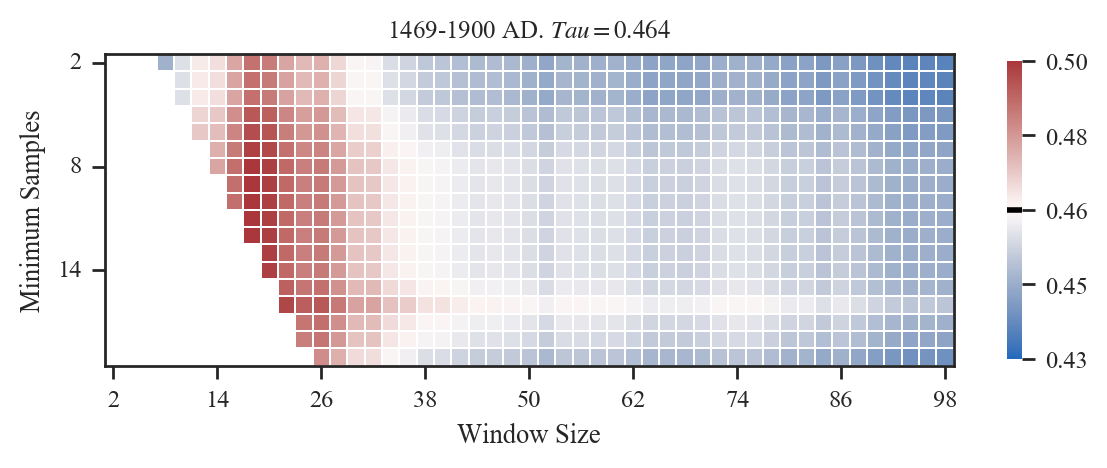

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_drought, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.


INFO | 保存删除 xu2023c 后的数据到 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/mac/xu2023c_del.csv。
INFO | 处理为对称等级 ...
INFO | 处理为标准化等级 ...
INFO | 通过随机采样处理为标准化等级，生成 100 个样本 ...
INFO | 开始计算历史数据和重建数据的相关性
INFO | cfg.agg_method=mean; cfg.to_int=True.
INFO | 开始计算相关性 kendall，时间切片: slice(1469, 1900, None)
INFO | 基准相关系数: 0.46020


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/data.py:218: RuntimeWarning: Mean of empty slice
  np.nanmean(data, axis=0),
/Users/songshgeo/Documents/VSCode/shifting_baseline/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


INFO | 最大相关性系数: 0.48446，改进百分比: 5.27%
INFO | 最大相关性系数年份: 16.0


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/compare.py:225: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  log.info("最大相关性系数年份: %s", float(filtered_df.idxmax().max()))


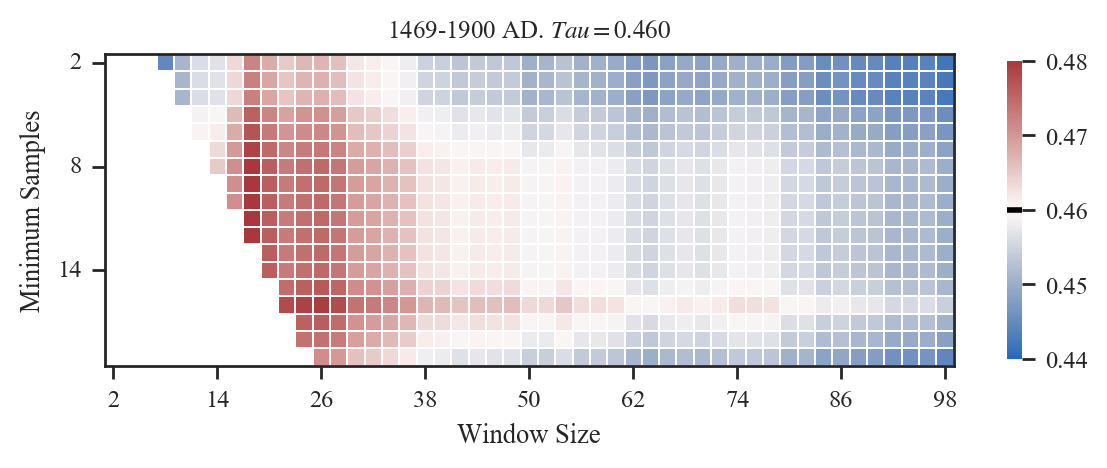

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_drought, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 17 seconds.


INFO | 保存删除 liu2020 后的数据到 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/mac/liu2020_del.csv。
INFO | 处理为对称等级 ...
INFO | 处理为标准化等级 ...
INFO | 通过随机采样处理为标准化等级，生成 100 个样本 ...
INFO | 开始计算历史数据和重建数据的相关性
INFO | cfg.agg_method=mean; cfg.to_int=True.
INFO | 开始计算相关性 kendall，时间切片: slice(1469, 1900, None)
INFO | 基准相关系数: 0.47906


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/data.py:218: RuntimeWarning: Mean of empty slice
  np.nanmean(data, axis=0),
/Users/songshgeo/Documents/VSCode/shifting_baseline/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


INFO | 最大相关性系数: 0.50796，改进百分比: 6.03%
INFO | 最大相关性系数年份: 16.0


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/compare.py:225: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  log.info("最大相关性系数年份: %s", float(filtered_df.idxmax().max()))


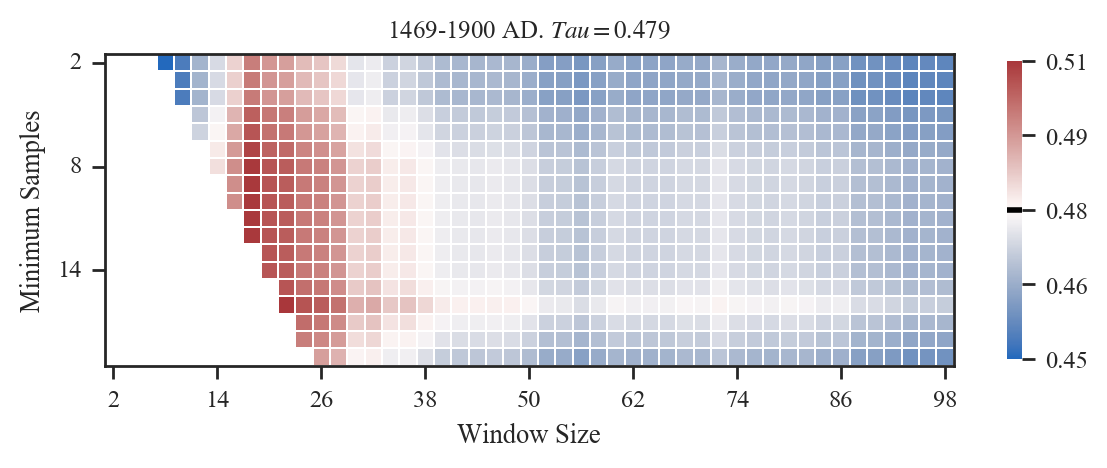

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_drought, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 23 seconds.


INFO | 保存删除 yi2012 后的数据到 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/mac/yi2012_del.csv。
INFO | 处理为对称等级 ...
INFO | 处理为标准化等级 ...
INFO | 通过随机采样处理为标准化等级，生成 100 个样本 ...
INFO | 开始计算历史数据和重建数据的相关性
INFO | cfg.agg_method=mean; cfg.to_int=True.
INFO | 开始计算相关性 kendall，时间切片: slice(1469, 1900, None)
INFO | 基准相关系数: 0.38373


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/data.py:218: RuntimeWarning: Mean of empty slice
  np.nanmean(data, axis=0),
/Users/songshgeo/Documents/VSCode/shifting_baseline/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


INFO | 最大相关性系数: 0.42179，改进百分比: 9.92%
INFO | 最大相关性系数年份: 16.0


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/compare.py:225: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  log.info("最大相关性系数年份: %s", float(filtered_df.idxmax().max()))


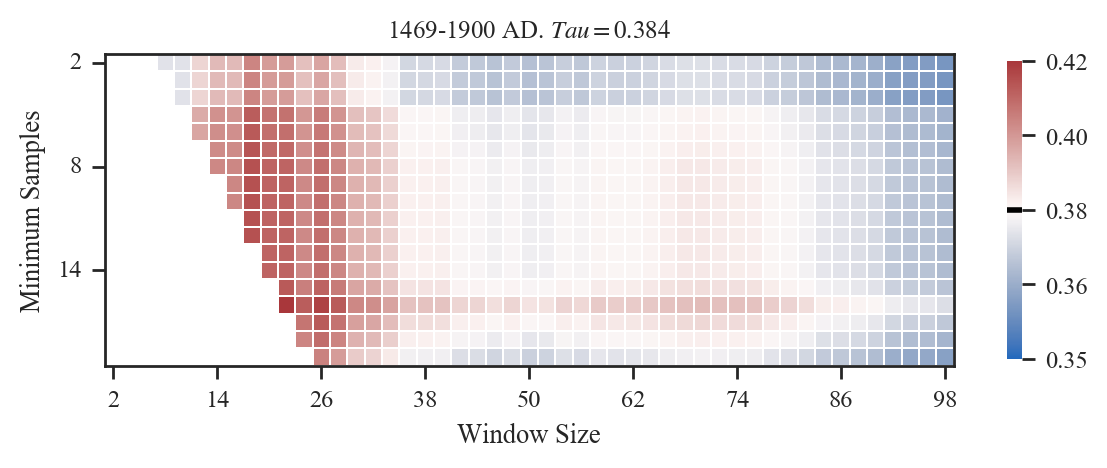

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_drought, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 20 seconds.


INFO | 保存删除 li2015b 后的数据到 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/mac/li2015b_del.csv。
INFO | 处理为对称等级 ...
INFO | 处理为标准化等级 ...
INFO | 通过随机采样处理为标准化等级，生成 100 个样本 ...
INFO | 开始计算历史数据和重建数据的相关性
INFO | cfg.agg_method=mean; cfg.to_int=True.
INFO | 开始计算相关性 kendall，时间切片: slice(1469, 1900, None)
INFO | 基准相关系数: 0.47307


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/data.py:218: RuntimeWarning: Mean of empty slice
  np.nanmean(data, axis=0),
/Users/songshgeo/Documents/VSCode/shifting_baseline/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


INFO | 最大相关性系数: 0.50693，改进百分比: 7.16%
INFO | 最大相关性系数年份: 16.0


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/compare.py:225: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  log.info("最大相关性系数年份: %s", float(filtered_df.idxmax().max()))


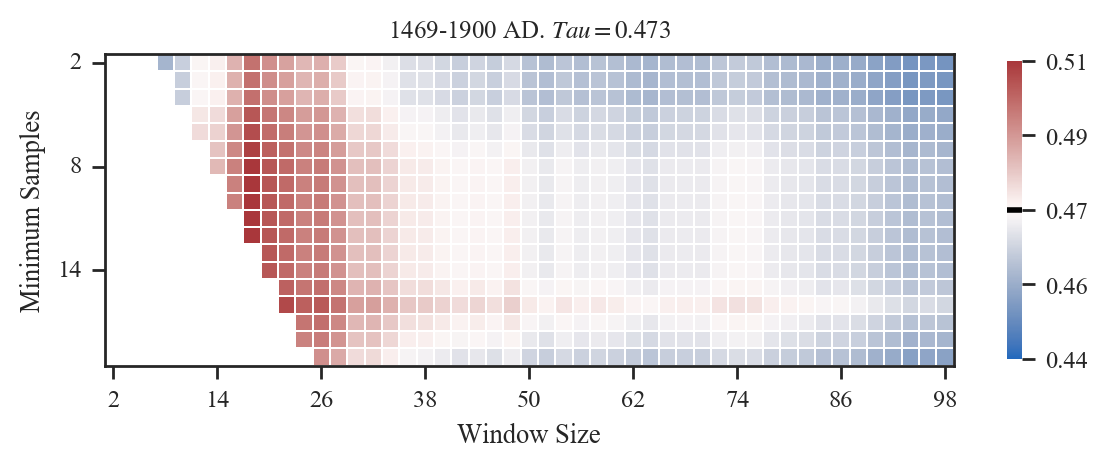

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [true_drought, nu]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.


INFO | 保存删除 li2019a 后的数据到 /Users/songshgeo/Documents/VSCode/shifting_baseline/data/mac/li2019a_del.csv。
INFO | 处理为对称等级 ...
INFO | 处理为标准化等级 ...
INFO | 通过随机采样处理为标准化等级，生成 100 个样本 ...
INFO | 开始计算历史数据和重建数据的相关性
INFO | cfg.agg_method=mean; cfg.to_int=True.
INFO | 开始计算相关性 kendall，时间切片: slice(1469, 1900, None)
INFO | 基准相关系数: 0.51956


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/data.py:218: RuntimeWarning: Mean of empty slice
  np.nanmean(data, axis=0),
/Users/songshgeo/Documents/VSCode/shifting_baseline/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


INFO | 最大相关性系数: 0.53496，改进百分比: 2.96%
INFO | 最大相关性系数年份: 16.0


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/compare.py:225: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  log.info("最大相关性系数年份: %s", float(filtered_df.idxmax().max()))


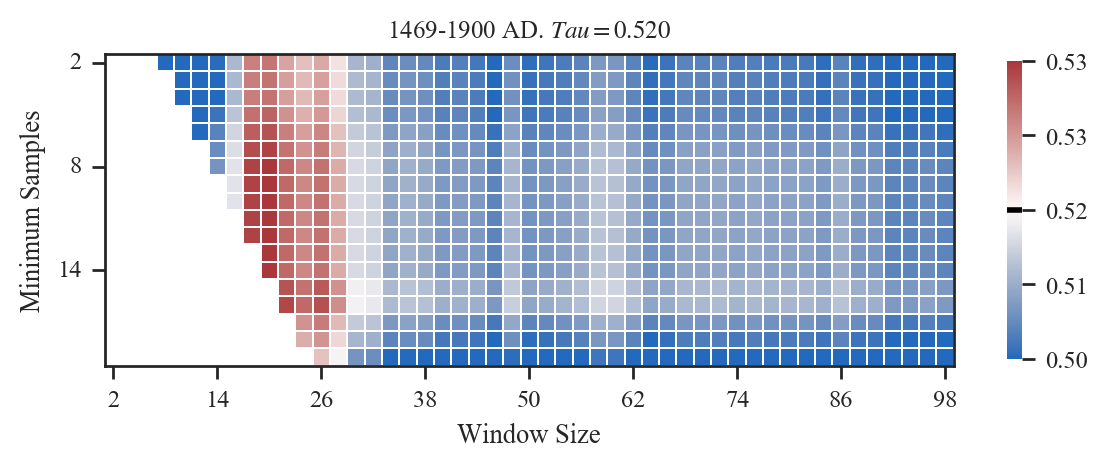

In [20]:
from pathlib import Path
from shifting_baseline.compare import experiment_corr_2d
from shifting_baseline.constants import STAGE1, STAGE2, END
from shifting_baseline.filters import calc_std_deviation


folder_path = Path(cfg.ds.processed) / cfg.ds.setname
if not folder_path.exists():
    folder_path.mkdir(parents=True, exist_ok=True)
    log.info(f"文件夹 {folder_path} 不存在，已创建")

# 测试每个数据都被导出一遍
test_corr = pd.Series()

for col in datasets:
    tmp_datsets = datasets.copy()
    tmp_uncertainties = uncertainties.copy()
    tmp_datsets.drop(columns=[col], inplace=True)
    tmp_uncertainties.drop(columns=[col], inplace=True)
    if (folder_path / f"{col}_del.csv").exists() and not cfg.recalculate_data:
        tmp_combined = pd.read_csv(folder_path / f"{col}_del.csv", index_col=0)
        log.info(f"读取删除 {col} 数据后的合成数据。")
    else:
        tmp_combined, tmp_trace = combine_reconstructions(
            tmp_datsets,
            tmp_uncertainties,
            standardize=True,
        )
        tmp_combined.to_csv(folder_path / f"{col}_del.csv")
        log.info(f"保存删除 {col} 后的数据到 {folder_path / f'{col}_del.csv'}。")
    test_corr[col] = best_val_series.corr(tmp_combined["mean"].loc[END:FINAL])

    # ================================================
    history.setup()
    # 实验参数
    slice_now = slice(STAGE1, END)

    log.info("开始计算历史数据和重建数据的相关性")
    log.info(f"cfg.agg_method={cfg.agg_method}; cfg.to_int={cfg.to_int}.")
    data1, data2 = history.aggregate(
        cfg.agg_method,
        inplace=True,
        to_int=cfg.to_int,
    ).merge_with(
        tmp_combined["mean"],
        time_range=slice_now,
        split=True,
    )

    fig, ax = plt.subplots(1, 1, figsize=(6, 2.5), tight_layout=True)
    df, r_benchmark, ax = experiment_corr_2d(
        data1=data1,
        data2=data2,
        time_slice=slice_now,
        corr_method=cfg.corr_method,
        filter_func=calc_std_deviation,
        filter_side=cfg.filter_side,
        ax=ax,
        n_diff_w=5,
        std_offset=0.1,
    )
    ax.set_title(
        f"{slice_now.start}-{slice_now.stop} AD. $Tau={r_benchmark:.3f}$",
        fontsize=9,
    )
    ax.locator_params(axis="x", nbins=9)  # x轴最多9个主刻度
    ax.locator_params(axis="y", nbins=4)  # y轴最多9个主刻度
    ax.tick_params(axis="both", rotation=0)
    plt.show()

ratio = (test_corr - validation_corr) / validation_corr
sensitive = pd.concat([test_corr, ratio], axis=1);

In [21]:
sensitive.columns = ["corr", "ratio"]
sensitive.index.name = "dataset"
sensitive.sort_values(by="corr", ascending=False, inplace=True)

sensitive
sensitive.to_csv(folder_path / "sensitivity.csv")

,corr,ratio
dataset,,
yang2019d,0.596122,0.124523
liu2020,0.567302,0.070157
li2019a,0.557131,0.050971
tan2011,0.534910,0.009054
li2015b,0.527133,-0.005618
yang2016,0.517525,-0.023741
yi2010,0.488710,-0.078099
xu2023c,0.472004,-0.109612
yi2012,0.464721,-0.123352


测试合并的数据，画出来怎么样

INFO | 处理为对称等级 ...
INFO | 处理为标准化等级 ...
INFO | 通过随机采样处理为标准化等级，生成 100 个样本 ...
INFO | 开始计算历史数据和重建数据的相关性
INFO | cfg.agg_method=mean; cfg.to_int=True.
INFO | 开始计算相关性 kendall，时间切片: slice(1469, 1900, None)
INFO | 基准相关系数: 0.46693


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/data.py:218: RuntimeWarning: Mean of empty slice
  np.nanmean(data, axis=0),
/Users/songshgeo/Documents/VSCode/shifting_baseline/.venv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


INFO | 最大相关性系数: 0.49524，改进百分比: 6.06%
INFO | 最大相关性系数年份: 16.0


/Users/songshgeo/Documents/VSCode/shifting_baseline/shifting_baseline/compare.py:225: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  log.info("最大相关性系数年份: %s", float(filtered_df.idxmax().max()))


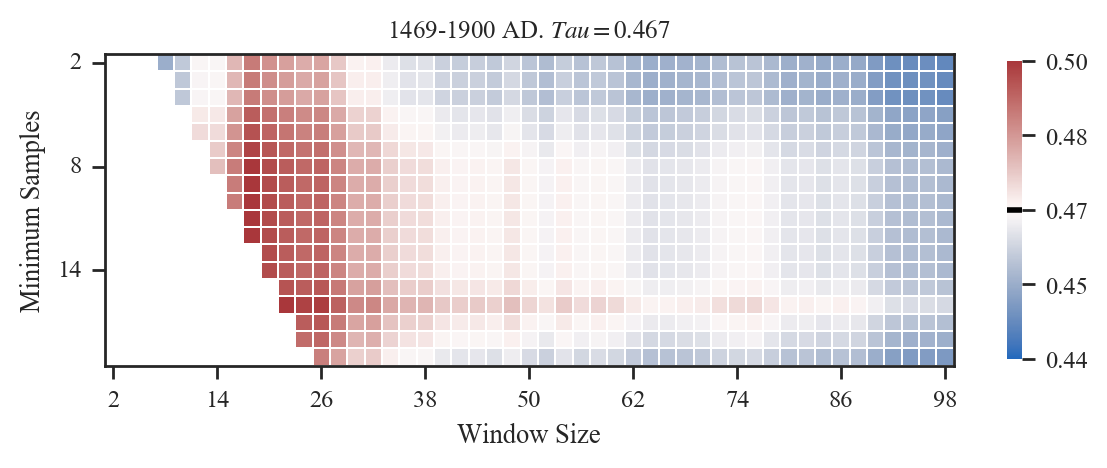

In [22]:
history.setup()
# 实验参数
slice_now = slice(STAGE1, END)

log.info("开始计算历史数据和重建数据的相关性")
log.info(f"cfg.agg_method={cfg.agg_method}; cfg.to_int={cfg.to_int}.")
data1, data2 = history.aggregate(
    cfg.agg_method,
    inplace=True,
    to_int=cfg.to_int,
).merge_with(
    combined["mean"],
    time_range=slice_now,
    split=True,
)

fig, ax = plt.subplots(1, 1, figsize=(6, 2.5), tight_layout=True)
df, r_benchmark, ax = experiment_corr_2d(
    data1=data1,
    data2=data2,
    time_slice=slice_now,
    corr_method=cfg.corr_method,
    filter_func=calc_std_deviation,
    filter_side=cfg.filter_side,
    ax=ax,
    n_diff_w=5,
    std_offset=0.1,
)
ax.set_title(
    f"{slice_now.start}-{slice_now.stop} AD. $Tau={r_benchmark:.3f}$",
    fontsize=9,
)
ax.locator_params(axis="x", nbins=9)  # x轴最多9个主刻度
ax.locator_params(axis="y", nbins=4)  # y轴最多9个主刻度
ax.tick_params(axis="both", rotation=0)
plt.show();